In [12]:
using DataFrames
ENV["COLUMNS"] = 12345678
using DelimitedFiles, CSV
using StatsBase: mean, mean_and_std, geomean
using Statistics: std
using JuMP, Cbc
using IterativeSolvers
using Plots
using Plots.Measures

## Get data

Collect data on American universities from the IPEDS database: https://nces.ed.gov/ipeds/datacenter/InstitutionByName.aspx?goToReportId=1

We are trying to predict the *demand* (number of entering students) at each of the $N$ schools as a function of the information available to that school. For each year $t$, we have the demand $d_n^{(t)}$ for each of the $N$ schools, as well as a matrix $U^{(t)}$ of endogeneous variables like average SAT scores, tuition etc. We assume that

$$d_n^{(t+1)} = \sum_{i=1}^N d_i^{(t)} x_i + \sum_{j=1}^N U_{n j}^{(t)} y_j + d_n^{(t)} z $$

in decision variables $x$, $y$, and $z$. That is, the demand for each school in a given year is a linear combination of the demand of *all* the schools in the previous year and the exogenous variables for *this* school in the previous year. Moreover, we assume (unreasonably, but it's the best we can do because we only have a few years of data) that this linear combination is the same for each school. 

In [13]:
"""
Read in `ipeds.csv` to a dataframe, drop NAs and blank columns.
"""
function readipeds()
    ipeds = CSV.File("ipeds.csv", drop=(i, name) -> i ≥ 185) |> DataFrame
    dropmissing!(ipeds)

    # Only work with schools whose enrollment is over 9000
    ipeds = ipeds[ipeds[:, "UGENTERN (EF2019D)"] .> 9000, :]
    return ipeds
end


"""
Read in `ipeds.csv` and process the data into Float64 arrays for computation.
"""
function makedata()
    ipeds = readipeds()
    
    # Variable names have changed slightly over the years;
    # this helps us match common columns
    datanames = [   "CINSON "  "CINSON "
                    "COTSON "  "COTSON "
                    "DVADM01"  "DVIC01 "
                    "DVADM04"  "DVIC04 "
                    "GBA4RTT"  "GBA4RTT"
                    "GBA6RTT"  "GBA6RTT"
                    "ACTCM25"  "ACTCM25"
                    "ACTCM75"  "ACTCM75"
                    "SATMT25"  "SATMT25"
                    "SATMT75"  "SATMT75"
                    "SATVR75"  "SATVR75"
                    "SATVR25"  "SATVR25"  ]

    years = 2006:2019

    T = length(years)
    N = size(ipeds)[1]
    M = size(datanames)[1]

    # demand[t, n] = demand for school n at year 2005+t
    demand = zeros(Float64, T, N)

    for t in 1:T
        dex = findfirst(x->occursin("UGENTERN", x) && occursin(string(years[t]), x), names(ipeds))
        demand[t, :] = ipeds[:, dex]
    end

    # exog[t, n, m] = value of exogeneous variable m at school n in year 2005+t
    exog = zeros(Float64, T, N, M)
    exog_names = ones(String, T, M)

    for t in 1:T, m in 1:M
        dex = findfirst(x-> (occursin(datanames[m, 1], x) || occursin(datanames[m, 2], x))
                            && occursin(string(years[t]), x),
                        names(ipeds))
        exog_names[t, m] = names(ipeds)[dex]
        if dex === nothing
            @show t, m
        end
        exog[t, :, m] = ipeds[:, dex]
    end

    weights = copy(demand)

    demand_ms = mean_and_std(demand)
    demand .-= demand_ms[1]
    demand ./= demand_ms[2]

    exog_ms = (mean(exog, dims=(1, 2)), std(exog, dims=(1, 2)))
    exog .-= exog_ms[1]
    exog ./= exog_ms[2]
    
    return demand, exog, weights
end

makedata

## Perform the estimation

Use both L2 (ridge) and L1 (lasso) regularization and compare results. For L2 regularization, the problem is a least-squares minimization problem and we use the LSMR algorithm from IterativeSolvers.jl to solve it quickly: https://iterativesolvers.julialinearalgebra.org/stable/linear_systems/lsmr/#IterativeSolvers.lsmr

This requires flattening the input data to get it into an $Ax = b$ kind of format.

In [14]:
"""
Compute an L2-regularized solution using the LSMR algorithm. Faster computation than
`estimate_lasso` but produces less sparsity.
"""
function estimate_lsmr(demand=demand, exog=exog, weights=weights)
    T, N, M = size(exog)
    
    # Flat demand vector
    b = zeros(Float64, N * (T-1))
    
    # Flat weight matrix
    w = similar(b)
    
    # 2D data matrix
    A = zeros(Float64, N * (T-1), N + M + 2)
    
    for t in 1:T-1, n in 1:N
        row = n + (t-1) * N
#         @show t, n, row
        
        # Or w = 1 to use unweighted penalty
        w[row] = sqrt(weights[t, n])
        
        # My demand next year 
        b[row] = demand[t+1, n] * w[row]

        # All demands this year
        A[row, 1:N] = demand[t, :] .* w[row]

        # My exogs this year
        A[row, N .+ (1:M)] = exog[t, n, :] .* w[row]

        # Bias
        A[row, N+M+1] = w[row]
        
        # Trend
        A[row, N+M+2] = demand[t, n] * w[row]
    end
    
        
    gammas = vcat(10.0 .^ range(-5, 5, length=21))
    trainerrors = Float64[]
    testerrors = Float64[]
    preds = Matrix{Float64}[]
    Xs = Vector{Float64}[]
    Ys = Vector{Float64}[]
    Zs = Vector{Float64}[]
    
    
    ls_soln = zeros(Float64, N + M + 2)
    pred_demand_vec = similar(b)
    pred_demand_mat = zeros(Float64, T-1, N)
    error_vec = similar(b)
    
    
    for l in gammas
        if l==0
            ls_soln[:] = A[1:end-N, :]\b[1:end-N]
        else
            # should be able to use lsmr! here but for some reason
            # the solution doesn't persist
            ls_soln[:] = lsmr(A[1:end-N, :], b[1:end-N]; λ = l)
        end
        
        # Still weighted, for reporting error
        pred_demand_vec[:] = (A * ls_soln)
        
        for t in 1:T-1, n in 1:N
            row = n + (t-1)*N
            # Remove weighting, for side-by-side comparison
            pred_demand_mat[t, n] = pred_demand_vec[row] / w[row]
        end
        
        error_vec[:] = pred_demand_vec - b
        
        push!(trainerrors, sum(error_vec[1:end-N] .^ 2))
        push!(testerrors, sum(last(error_vec, N) .^ 2))
        push!(preds, copy(pred_demand_mat))
        push!(Xs, copy(ls_soln[1:N]))
        push!(Ys, copy(ls_soln[N+1:end-2]))
        push!(Zs, copy(ls_soln[end-1:end]))
    end
    
    return (; gammas, trainerrors, testerrors, preds, Xs, Ys, Zs)
end

estimate_lsmr

For the lasso, we manually enter the optimization program into a QP solver. I use the Ipopt solver with the JuMP interface.

In [27]:
function estimate_lasso(demand=demand, exog=exog, weights=weights)
    T, N, M = size(exog)
        
    model = Model(Cbc.Optimizer)
    
    set_silent(model)
    
    @variable(model, X[1:N])
    @variable(model, AbsX[1:N])
    
    # Last two entries are bias and trend terms
    @variable(model, Y[1:M+2])
    @variable(model, AbsY[1:M+2])
    
    @variable(model, AbsTrainError[2:T-1, 1:N])
    
    @constraint(model, AbsX .≥ X .* N * M * 1e6)
    @constraint(model, AbsX .≥ -X .* N * M * 1e6)
    
    @constraint(model, AbsY .≥ Y .* N * M * 1e6)
    @constraint(model, AbsY .≥ -Y .* N * M * 1e6)

    @expression(model, PredDemand[t in 2:T, n in 1:N],
                sum(X[j] * demand[t-1, j] for j in 1:N) +
                sum(Y[m] * exog[t-1, n, m] for m in 1:M) + 
                Y[M+1] + 
                Y[M+2] * demand[t-1, n])
    
    # Save year T for validation
    @expression(model, TrainError[t in 2:T-1, n in 1:N],
                weights[t, n] *   # Weight errors by size of demand
                (PredDemand[t, n] - demand[t, n]) )
    
    @constraint(model, ErrorAbs1, AbsTrainError .≥ TrainError)
    @constraint(model, ErrorAbs2, AbsTrainError .≥ -TrainError)
    
    @expression(model, Lasso,
                    sum(AbsX[n] for n in 1:N) +
                    sum(AbsY[m] for m in 1:M+2))
    
    
    gammas = vcat(10.0 .^ range(-5, 5, length=21))
    trainerrors = Float64[]
    testerrors = Float64[]
    preds = Matrix{Float64}[]
    Xs = Vector{Float64}[]
    Ys = Vector{Float64}[]
    Zs = Vector{Float64}[]
    
    for g in gammas
        @objective(model, Min, TrainError + g * Lasso)
        
        optimize!(model)
        @show g
        
        println("  Termination status: ", termination_status(model))
        println()

        AbsTestError = sum(abs(weights[T, n] * (value.(PredDemand[T, n]) - demand[T, n])) for n in 1:N)
            
        push!(trainerrors, value.(AbsTrainError))
        push!(testerrors, AbsTestError)
        push!(preds, value.(PredDemand).data)
        push!(Xs, value.(X))
        push!(Ys, value.(Y[1:M]))
        push!(Zs, value.(Y[end-1:end]))
    end

    return (; gammas, trainerrors, testerrors, preds, Xs, Ys, Zs)
end

estimate_lasso (generic function with 4 methods)

Some helper functions to help us visualize the output and judge which level of regularization is appropriate.

In [21]:
function elbowlocatorplot(res)
    pl = plot(legend=:bottomleft, xlabel="γ", ylabel="sum of squared errors",
              yscale=:log10, xscale=:log10, yticks=nothing,
              leftmargin=15pt)

    plot!(pl, label="train",
          res.gammas, max.(eps(), res.trainerrors ./ geomean(res.trainerrors))), 
    plot!(pl, label="test",
          res.gammas, max.(eps(), res.testerrors ./ geomean(res.testerrors)))

    return pl
end

function bestscatter(res)
    best_idx = argmin(res.testerrors)
    
    cs = palette(:cividis, length(res.gammas))

    pl = plot(legend=:bottomright, xlabel="demand (true)", ylabel="demand (predicted)")
    scatter!(pl,
             demand[end, :],
             res.preds[best_idx][end, :],
              msw=0, ma=0.5, ms=3,
             label="γ = $(round(res.gammas[best_idx], sigdigits=2))")

    return pl
end

function sparsitymap(res)
    best_idx = argmin(res.testerrors)
    
    N = length(res.Xs[best_idx])
    M = length(res.Ys[best_idx])
    
    pl = plot(colorbar=false, size=(600, 600), legend=:topright,
              xlabel="γ = $(round(res.gammas[best_idx], sigdigits=2))")
    
    kws = Dict(:orientation=>:h, :yflip=>true, :lw=>0, :bar_width=>1.05)
    
    bar!(pl, 1:N, res.Xs[best_idx], 
         c=:cornflowerblue, label="demand at other schools"; kws...)
    
    bar!(pl, N .+ (1:M), res.Ys[best_idx],
        c=:gold, label="endogenous variables"; kws...)
    
    bar!(pl, N + M .+ (1:2), res.Zs[best_idx],
         c=:olivedrab, label="bias and trend"; kws...)
    
    return pl
end

sparsitymap (generic function with 1 method)

## Compare results

### L2 regularization

In [22]:
demand, exog, weights = makedata()
res_lsmr = estimate_lsmr()
keys(res_lsmr)
# Warning doesn't matter

┌ Warning: thread = 1 warning: only found 184 / 185 columns around data row: 2807. Filling remaining columns with `missing`
└ @ CSV /Users/maxkapur/.julia/packages/CSV/Zl2ww/src/file.jl:612


(:gammas, :trainerrors, :testerrors, :preds, :Xs, :Ys, :Zs)

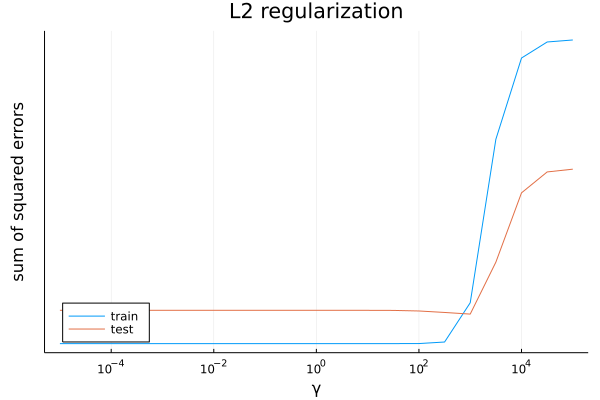

In [23]:
elbowlocatorplot(res_lsmr); plot!(title="L2 regularization")

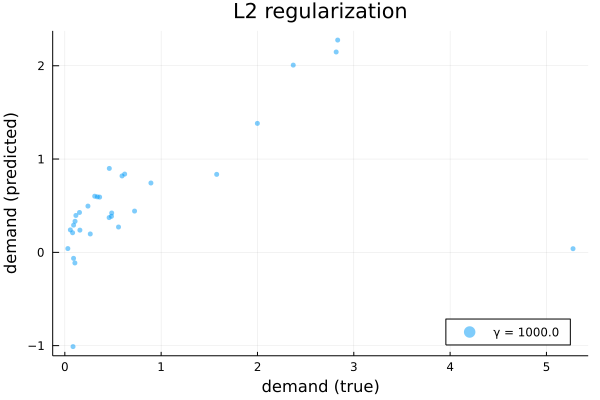

In [24]:
bestscatter(res_lsmr); plot!(title="L2 regularization")

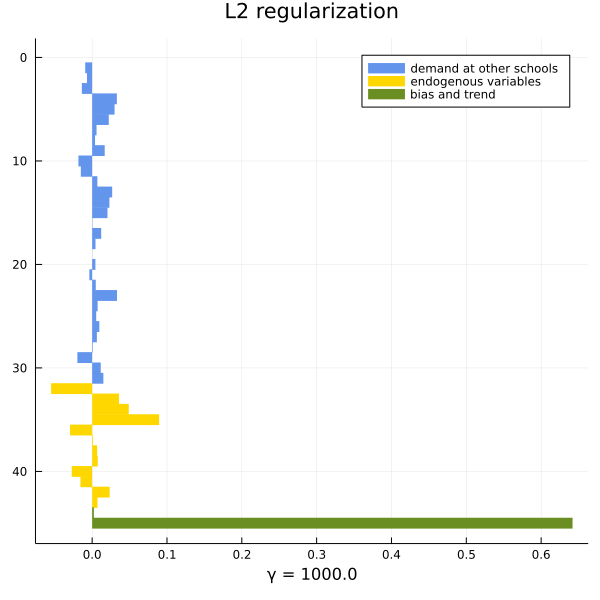

In [25]:
sparsitymap(res_lsmr); plot!(title="L2 regularization")

# L1 regularization

In [28]:
res_lasso = estimate_lasso()
keys(res_lasso)

LoadError: MethodError: no method matching similar(::Type{Array{AffExpr, N} where N}, ::Tuple{UnitRange{Int64}, Base.OneTo{Int64}})
[0mClosest candidates are:
[0m  similar([91m::StructArrays.StructArray{T, N, C, I} where {N, C<:Union{Tuple, NamedTuple}, I}[39m, ::Tuple) where T at /Users/maxkapur/.julia/packages/StructArrays/GhBGM/src/structarray.jl:283
[0m  similar([91m::AbstractArray{T, N} where N[39m, ::Tuple) where T at abstractarray.jl:740
[0m  similar(::Type{A}, [91m::Type{T}[39m, [91m::StaticArrays.Size{S}[39m) where {A<:Array, T, S} at /Users/maxkapur/.julia/packages/StaticArrays/0yhGP/src/abstractarray.jl:163
[0m  ...

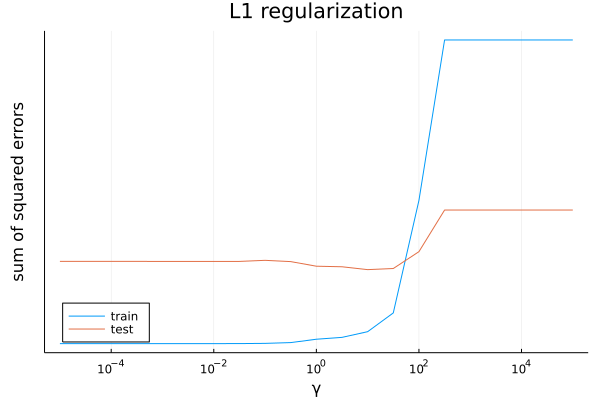

In [257]:
elbowlocatorplot(res_lasso); plot!(title="L1 regularization")

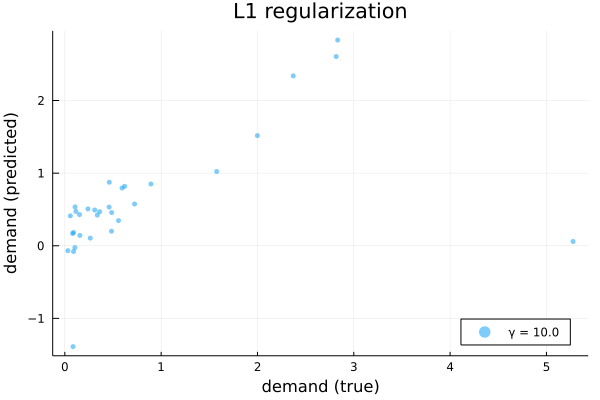

In [258]:
bestscatter(res_lasso); plot!(title="L1 regularization")

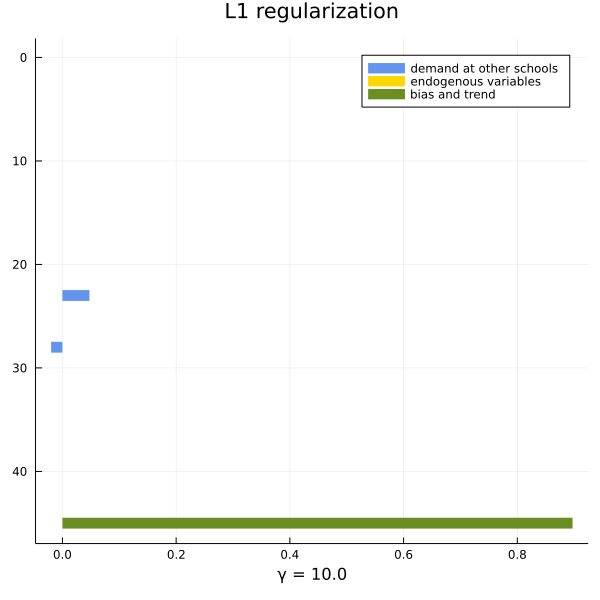

In [259]:
sparsitymap(res_lasso); plot!(title="L1 regularization")

In [235]:
res_lasso.Xs[argmin(res_lasso.testerrors)]

31-element Vector{Float64}:
  2.276826632507876e-14
 -1.2139060627746407e-15
 -2.949013902414388e-15
  1.1951194267486945e-15
 -2.4035299169559213e-16
 -3.7033065067484657e-17
  1.3757970615468353e-16
  6.568808142124719e-16
  1.2091806608211043e-15
 -2.4306005463147917e-15
 -1.5055472067386186e-15
 -4.1098477334144376e-16
  2.586091028635015e-15
  ⋮
 -4.383770434720513e-15
 -1.3365957168871908e-15
 -5.029233593673882e-15
  0.04753474230297546
 -2.4624740839497627e-15
 -4.687651021603508e-16
  1.396638208808615e-15
 -1.297569306829488e-15
 -0.019882631615713194
 -1.0885664880585905e-15
 -1.2916325412360247e-15
 -1.0627824465129065e-15